# Should Robots Be Obedient?

This is the accompanying Jupyter notebook for the paper  
*"Should Robots Be Obedient?" Smitha Milli, Dylan Hadfield-Menell, Anca Dragan, and Stuart Russell.* [arxiv]()

Every experiment in the paper can be replicated by running this notebook. In addition, it should be easy to play around and explore your own ideas.

In [3]:
%matplotlib inline
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math, csv

In [4]:
default_palette = sns.cubehelix_palette(5, start=2.6, rot=0, dark=0.1, light=.8)
sns.set_style('white')
sns.set_context('paper', font_scale=1.4)
sns.set_style({
    'axes.linewidth' : 0.5, 
    'axes.edgecolor': '#cccccc',
    'lines.markersize': 3,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'lines.marker': 'o',
    'markers.fillstyle': 'full',
    'errorbar.capsize': 2
})
sns.despine()

In [6]:
class Game:
    
    def __init__(self, num_actions, horizon,
                 reward_mean_prior, reward_cov_prior,
                 feat_mean_prior, feat_cov_prior):
        """
        Params:
            reward_mean_prior [np.ndarray]: E[theta]
            reward_cov_prior [np.ndarray]: Cov[theta]
            feat_mean_prior [np.ndarray]: E[phi]
            feat_cov_prior [np.ndarray]: Cov[phi]
            num_actions [int]: number of actions at each step
            horizon [int]: horizon of game
        """
        self.reward_mean_prior = reward_mean_prior
        self.reward_cov_prior = reward_cov_prior
        self.feat_mean_prior = feat_mean_prior
        self.feat_cov_prior = feat_cov_prior
        self.num_true_feats = len(self.feat_mean_prior)
        self.num_extra_feats = len(feat_mean_prior) - len(reward_mean_prior)
        self.feat_weights = np.random.multivariate_normal(
            self.reward_mean_prior, self.reward_cov_prior)
        self.feat_weights = np.hstack(
            [self.feat_weights, np.zeros(self.num_extra_feats)])
        self.num_actions = num_actions
        self.horizon = horizon
        self.action_matrix = np.random.multivariate_normal(
            self.feat_mean_prior, self.feat_cov_prior, 
            size=(self.horizon, self.num_actions))
        self.action_vals = np.dot(self.action_matrix, self.feat_weights.T)
        
    def get_reward(self, action, time):
        reward = self.action_vals[time][action]
        return reward
    
    def get_max_reward(self, time):
        return np.max(self.action_vals[time])
    
    def get_action_matrix_at_steps(self, steps):
        return self.action_matrix[steps]
    
    def get_action_matrix(self, max_step=None):
        if max_step:
            return self.action_matrix[:max_step]
        return self.action_matrix
        
class Human:
    
    def __init__(self, rationality):
        self.rationality = rationality
        
    def get_orders(self, game):
        probs = self.get_prob_orders(game.action_vals)
        inds = np.arange(game.num_actions)
        orders = np.array(
            [np.random.choice(inds, p=probs[i]) for i in range(len(probs))])
        return orders
    
    def get_prob_orders(self, action_vals):
        human_vals = action_vals/self.rationality
        max_vals = np.array(np.max(human_vals, axis=1))[:,np.newaxis]
        human_vals = human_vals - max_vals
        unnormalized_probs = np.exp(human_vals)
        normalizations = np.sum(unnormalized_probs, axis=1)
        probs = unnormalized_probs/normalizations[:,np.newaxis]
        return probs
        
class Robot:
    
    def __init__(self, num_feats):
        """
        Params:
            num_feats [int]: the number of feats the robot thinks theta has
        """
        self.num_feats = num_feats
        
    def choose_action(self, game, time, theta_est):
        action_matrix = game.action_matrix[time,:,:self.num_feats]
        robot_action = np.argmax(np.matmul(action_matrix, theta_est))
        return robot_action
    
    def get_robot_action_matrix(self, action_matrix):
        """
        Truncates action matrix to features that robot thinks are important.
        """
        return action_matrix[:,:,:self.num_feats]

    def calc_mle_theta(self, orders, action_matrix, human, max_iter=500):
        """
        Params:
            orders [list(int)]: the action ids the human chooses at diff rounds
            action_matrix [np.array((num_steps, num_actions, num_feats))]: 
                the feature vectors for the rounds corresponding to orders
            human [Human]
        """
        theta = np.zeros(self.num_feats)
        action_matrix = self.get_robot_action_matrix(action_matrix)
        empirical_feats = action_matrix[[i for i in range(len(orders))], orders]
        empirical_feats = np.sum(empirical_feats, axis=0)
        expected_feats = np.zeros(len(empirical_feats))
        diff = empirical_feats - expected_feats
        i = 0
        while np.linalg.norm(diff) > 0.1 and i < max_iter:
            action_vals = np.matmul(action_matrix, theta)
            prob_orders = human.get_prob_orders(action_vals)
            expected_feats = action_matrix * prob_orders[:,:,np.newaxis]
            expected_feats = np.sum(expected_feats, axis=(0, 1))
            diff = empirical_feats - expected_feats # gradient
            theta += 1/(i+1) * diff
            if any(np.isnan(diff)):
                print(expected_feats)
            i += 1
        return theta
    
def get_obedience(robot_action, order):
    return 1 if robot_action == order else 0

# Autonomy Advantage vs Obedience

Autonomy advantage and obedience come at a tradeoff. Following code reproduces exps shown in Figure 1a and 1b.

In [8]:
def get_data_at_time(game, robot, human, orders, time):
    """
    Returns [obedience, is opt order, adv, max adv]
    """
    prev_orders = orders[:time+1]
    curr_order = prev_orders[-1]
    theta_est = robot.calc_mle_theta(
        prev_orders, game.get_action_matrix(len(prev_orders)), human)
    robot_action = robot.choose_action(game, time, theta_est)
    obd = get_obedience(robot_action, curr_order)
    human_reward = game.get_reward(curr_order, time)
    max_reward = game.get_max_reward(time)
    is_order_opt = 1 if human_reward == max_reward else 0
    adv = game.get_reward(robot_action, time) - human_reward
    max_adv = max_reward - human_reward
    return np.array([obd, is_order_opt, adv, max_adv])

def get_mean_stderr(data):
    mean = np.average(data, axis=0)
    std_error = np.sqrt(np.sum(np.square(data - mean), axis=0))/len(data)
    return mean, std_error

def sim_adv_obd_by_time(
    rationality=2, num_feats=10, num_actions=10, horizon=50, time_step=5, num_sims=100):
    times = range(0, horizon+1, time_step)
    # last index is [obedience, is order opt, adv, max adv]
    data = np.zeros((num_sims, len(times), 4))
    human = Human(rationality)
    robot = Robot(num_feats)
    for sim_num in range(num_sims):
        game = Game(num_actions, horizon+1, 
            np.zeros(num_feats), np.identity(num_feats), 
            np.zeros(num_feats), np.identity(num_feats))
        orders = human.get_orders(game)
        for time_ind, time in enumerate(times):
            data[sim_num][time_ind] = get_data_at_time(game, robot, human, orders, time)
    return data, times
    
def plot_sim_by_time(exps, times, ylabel, data_labels, linestyles):
    plt.figure()
    for exp_ind, data_label, linestyle in zip(
        range(exps.shape[-1]), data_labels, linestyles):
        mean, stderr = get_mean_stderr(exps[:,:,exp_ind])
        (_, caps, _) = plt.errorbar(
            times, mean, yerr=stderr, marker='o', 
            label=data_label, capsize=2, linestyle=linestyle)
        for cap in caps:
            cap.set_markeredgewidth(1)
        plt.xlabel('Time')
    plt.legend()
    plt.ylabel(ylabel)
    plt.locator_params(axis='y', nbins=3)
    sns.despine()
    
def save_adv_obd_data(filename, data, times):
    """
    Saves the adv and obed by time data in a csv file.
    """
    csv_data = np.zeros((data.shape[1], 1 + 2*data.shape[2]))
    csv_data[:, 0] = times
    for exp_ind in range(data.shape[-1]):
        mean, std = get_mean_stderr(data[:,:,exp_ind])
        csv_data[:,1+2*exp_ind] = mean
        csv_data[:, 2+2*exp_ind] = std
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time', 'Obedience', 'Obedience Error', 'Opt Order', 'Opt Order Error', 
                         'Advantage', 'Advantage Error', 'Maximum Advantage', 'Maximum Advantage Error'])
        writer.writerows(csv_data)
        
def fig_1ab(num_sims=100, save_file=None):
    data, times = sim_adv_obd_by_time(num_sims=num_sims, time_step=10, horizon=100)
    if save_file:
        save_adv_obd_data(save_file, data, times)
    plot_sim_by_time(data[:,:,:2], times, 'Obedience ($\mathcal{O}$)', 
        ['Robot obedience', 'Prob opt order'], ['-', '--'])
    plot_sim_by_time(data[:,:,2:4], times, 'Autonomy Advantage ($\Delta$)', 
        ['Advantage', 'Max advantage'], ['-', '--'])

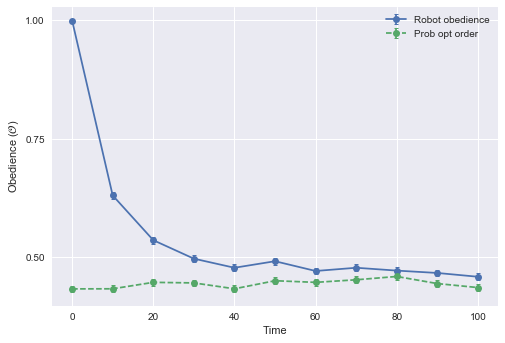

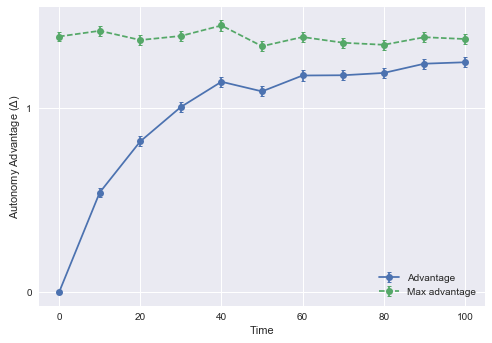

In [104]:
fig_1ab(num_sims=5000, save_file='fig1ab.csv')

# Effect of Rationality on Autonomy Advantage

Eventually, the robot can gain a higher autonomy advantage for more irrational humans. But, with a more rational human it takes longer for the robot to converge to the maximum advantage because the evidence the robot gets about the reward is noisier. Following code reproduces experiment shown from Figure 2.

In [1]:
def sim_adv_by_rat(rationalities, times, num_feats=10, num_actions=10, num_sims=100):
    horizon = max(times)
    robot = Robot(num_feats)
    humans = [Human(rationality) for rationality in rationalities]
    data = np.zeros((len(times), num_sims, len(rationalities)))
    max_advs = np.zeros((num_sims*len(times), len(rationalities)))
    for sim_num in range(num_sims):
        game = Game(num_actions, horizon+1, 
            np.zeros(num_feats), np.identity(num_feats), 
            np.zeros(num_feats), np.identity(num_feats))
        for human_ind, human in enumerate(humans):
            orders = human.get_orders(game)
            for time_ind, time in enumerate(times):
                curr_data = get_data_at_time(game, robot, human, orders, time)
                data[time_ind][sim_num][human_ind] = curr_data[2]
                max_advs[sim_num*len(times)+time_ind][human_ind] = curr_data[3]
    return data, max_advs

def plot_adv_by_rat(data, rationalities, max_advs, times):
    palette = sns.cubehelix_palette(5, start=2.6, rot=0, dark=0.1, light=.8)
    for time, exp_at_time in zip(times, data):
        mean, stderrs = get_mean_stderr(exp_at_time)
        with palette:
            (_, caps, _) = plt.errorbar(x=rationalities, y=mean, yerr=stderrs, 
                label='{0}'.format(time), marker='o', markersize=4)
            for cap in caps:
                cap.set_markeredgewidth(1)
    mean, stderrs = get_mean_stderr(max_advs)
    (_, caps, _) = plt.errorbar(x=rationalities, y=mean, yerr=stderrs,
                 label='$\infty$', linestyle='--', color=palette[-1], marker='o', markersize=4)
    for cap in caps:
        cap.set_markeredgewidth(1)
    plt.xticks(np.arange(0, max(rationalities)+1, 1.0))
    #plt.locator_params(axis='y', nticks=3)
    #plt.locator_params(axis='x', nticks=3)
    plt.xlim(min(rationalities))
    plt.legend(loc='upper left', title= 'Time:')
    
def save_adv_by_rat_data(filename, data, rationalities, max_advs, times):
    # copy and pasted from above csv
    csv_data = []
    for time, exp_at_time in zip(times, data):
        mean, stderrs = get_mean_stderr(exp_at_time)
        csv_data.append([time] + mean.tolist() + stderrs.tolist())
    max_adv_mean, max_adv_err = get_mean_stderr(max_advs)
    csv_data.append(['Max'] + max_adv_mean.tolist() + max_adv_err.tolist())
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Time'] + ['Rationality: {0}'.format(rat) for rat in rationalities]
                        + ['Stderr Rationality: {0}'.format(rat) for rat in rationalities])
        writer.writerows(csv_data)

def fig2(num_sims, save_file=None):
    rationalities = [1, 2, 5, 10]
    times = [0, 10, 100, 500]
    data, max_advs = sim_adv_by_rat(rationalities, times, num_sims=num_sims, num_actions=10)
    if save_file is not None:
        save_adv_by_rat_data(save_file, data, rationalities, max_advs, times)
    plot_adv_by_rat(data, rationalities, max_advs, times)

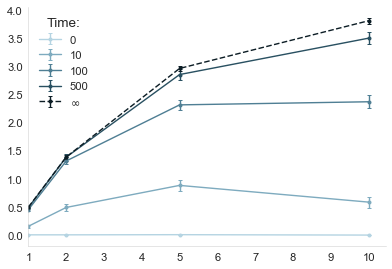

In [9]:
fig2(num_sims=1000, save_file='fig2.csv')

# Model Misspecification of Features

If the robot has the wrong model of the space of reward parameters, the autonomy advantage can easily turn into the rebellion regret. Figure 3 shows how autonomy advantage changes as a function of the number of features the robot has.

If the human is rational enough, MLE-R should almost always obey on the first order. Thus, one way R can detect a misspecified $\Theta$ is to estimate its obedience to H's first order. If R's obedience is too low, R probably has the wrong model. Figure 4 shows the improvement in performance with a robot that tries detecting misspecification.

Following code reproduces experiments from Figure 3 and 4.

In [210]:
def sim_wrong_feats(
    time_step, pos_num_feats, true_num_feats,
    rationality=2, num_actions=10, num_sims=1000,
    cutoff=0.8, calc_sample_obed=False):
    """
    Params:
        -time_step [int]: the step of game to calculate adv/obedience for
        -pos_num_feats [list(int)]: all possible num of features that robot could believe reward has
        -true_num_feats [int]: the true number of features the reward has
        -cutoff [float]: if sample obedience is less than this cutoff, act obediently
        -rationality [float]: rationality of human
        -num_actions [int]
        -num_sims [int]
    
    Returns:
        adv_exp, obd_exp, detect_adv_exp, detect_obd_exp
    """
    robots = [Robot(num_feats) for num_feats in pos_num_feats]
    human = Human(rationality)
    pos_num_feats = sorted(pos_num_feats)
    max_num_feats = pos_num_feats[-1]
    adv_exp, obd_exp, detect_adv_exp, detect_obd_exp = [
        np.zeros((num_sims, max_num_feats)) for _ in range(4)]
    if not calc_sample_obed:
        detect_adv_exp, detect_obd_exp = None, None
    for sim in range(num_sims):
        game = Game(num_actions, time_step + 1, 
            np.zeros(true_num_feats), np.identity(true_num_feats), 
            np.zeros(max_num_feats), np.identity(max_num_feats))
        orders = human.get_orders(game)
        curr_order = orders[-1]
        human_reward = game.get_reward(curr_order, time_step)
        for num_feats, robot in zip(pos_num_feats, robots):
            theta_est = robot.calc_mle_theta(orders, game.get_action_matrix(len(orders)), human)
            robot_action = robot.choose_action(game, time_step, theta_est)
            obd = get_obedience(robot_action, curr_order)
            adv = game.get_reward(robot_action, time_step) - human_reward
            adv_exp[sim][num_feats-1] = adv
            obd_exp[sim][num_feats-1] = obd
            if calc_sample_obed:
                sample_obedience = calc_sample_obedience(robot, orders[:-1], game, human)
                if sample_obedience < cutoff:
                    detect_adv_exp[sim][num_feats-1] = 0
                    detect_obd_exp[sim][num_feats-1] = 1
                else:
                    detect_adv_exp[sim][num_feats-1] = adv
                    detect_obd_exp[sim][num_feats-1] = obd
    return adv_exp, obd_exp, detect_adv_exp, detect_obd_exp

def plot_wrong_feats(exp, pos_num_feats, true_num_feats, ylabel='', title=''):
    plt.figure()
    red = sns.color_palette('muted')[2]
    green = sns.color_palette('muted')[1]
    means, stderrs = get_mean_stderr(exp)
    (_, caps, _) = plt.errorbar(x=pos_num_feats, y=means, yerr=stderrs, 
        marker='o', markersize=4)
    for cap in caps:
        cap.set_markeredgewidth(1)
    #plt.locator_params(axis='x', nticks=2)
    plt.xlim(min(pos_num_feats))
    plt.xticks([
        min(pos_num_feats), true_num_feats, max(pos_num_feats)])
    ymin, ymax = plt.gca().get_ylim()
    plt.yticks([ymin, 0, ymax])
    plt.xlabel('Number Features')
    plt.ylabel(ylabel)
    plt.title(title)
    #plt.legend(loc='upper left', title= 'Time:')
    
def plot_mult_exps(exps, steps, true_num_feats, yticks=None, ylabel=''):
    red = sns.color_palette('muted')[2]
    green = sns.color_palette('muted')[1]
    f, axes = plt.subplots(1, len(exps), sharey=True, figsize=(10, 3))
    for i, (ax, step, exp) in enumerate(zip(axes, steps, exps)):
        ttl = ax.set_title('Step {0}'.format(step))
        ttl.set_position([.5, 1.05])
        if i == 0:
            ax.set_ylabel(ylabel)
        max_feats = exp.shape[1]
        mean, stderr = get_mean_stderr(exp)
        ax.errorbar(range(1, true_num_feats + 1), mean[:true_num_feats], 
                    yerr=stderr[:true_num_feats], color=red)
        ax.errorbar(range(true_num_feats, max_feats + 1), mean[true_num_feats-1:], 
                    yerr=stderr[true_num_feats-1:], color=green)
        ax.axvline(x=true_num_feats, color=default_palette[-1], linestyle='--', 
                   linewidth=0.25, marker=None)
        if yticks is None:
            start, end = ax.get_ylim()
            ax.set_yticks([int(min(start, mean.min())), 0, int(max(mean.max(), end))])
        else:
            ax.set_yticks(yticks)
        ax.set_xlim(xmin=1)
        ax.set_xticks([1, true_num_feats, len(mean)])
    
def calc_sample_obedience(robot, orders, game, human):
    """
    Calculates sample obedience to first order.
    """
    sample_obed = 0
    for step, order in enumerate(orders):
        theta_est = robot.calc_mle_theta(
            [order], game.get_action_matrix_at_steps(np.array([step])), human)
        robot_action = robot.choose_action(game, step, theta_est)
        curr_obed = 1 if robot_action == order else 0
        sample_obed += curr_obed
    sample_obed /= len(orders)
    return sample_obed
        
def plot_detect_adv(adv_exp, detect_adv_exp, true_num_feats, title='', xlabel='', ylabel=''):
    red = sns.color_palette('muted')[2]
    green = sns.color_palette('muted')[1]
    tint_factor = 0.9
    muted_red = red + (0.4,)
    muted_green = green + (0.4,)
    f, ax = plt.subplots()
    ttl = ax.set_title(title)
    ttl.set_position([.5, 1.05])
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    for i, exp in enumerate([detect_adv_exp, adv_exp]):
        max_feats = exp.shape[1]
        mean, stderr = get_mean_stderr(exp)
        if i == 0:
            red_color = red
            green_color = green
        else:
            red_color = muted_red
            green_color = muted_green
        ax.errorbar(range(1, true_num_feats + 1), mean[:true_num_feats], 
                    yerr=stderr[:true_num_feats], color=red_color)
        ax.errorbar(range(true_num_feats, max_feats + 1), mean[true_num_feats-1:], 
                    yerr=stderr[true_num_feats-1:], color=green_color)
        ax.axvline(x=true_num_feats, color=default_palette[-1], linestyle='--', 
                   linewidth=0.25, marker=None)
        ax.locator_params(axis='y', nbins=3)
        start, end = ax.get_ylim()
        ax.set_yticks([int(min(start, mean.min())), 0, int(max(mean.max(), end))])
    ax.set_xlim(xmin=1)
    ax.set_xticks([1, true_num_feats, len(mean)])
    
def write_exp(save_file, pos_num_feats, exps):
    with open(save_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        header = ['Features', 'Adv', 'Adv Err', 'Obd', 'Obd Err', 'Detect Adv', 'Detect Adv Err']
        writer.writerow(header)
        rows = np.zeros((len(pos_num_feats), len(header)))
        rows[:,0] = pos_num_feats
        for i, exp in enumerate(exps):
            mean, stderr = get_mean_stderr(exp)
            rows[:,2*i+1] = mean
            rows[:,2*i+2] = stderr
        writer.writerows(rows)

In [214]:
def sim_fig34(num_sims=100, save_file_prefix=''):
    """
    Simulates Figure 3 and 4.
    """
    steps = [0, 10, 100]
    pos_num_feats = range(1, 21)
    detect_at = 10
    true_num_feats = 10
    adv_exps, obd_exps = [], []
    for step in steps:
        if detect_at == step:
            calc_sample_obed=True
        else:
            calc_sample_obed=False
        adv_exp, obd_exp, detect_adv_exp, detect_obd_exp = sim_wrong_feats(
            time_step=step, pos_num_feats=pos_num_feats, 
            true_num_feats=true_num_feats, 
            rationality=2, num_sims=num_sims, calc_sample_obed=calc_sample_obed)
        if detect_at == step:
            # Figure 4
            plot_detect_adv(adv_exp, detect_adv_exp, true_num_feats, 
                title='Step 10', xlabel='Number Features', ylabel='Autonomy Advantage ($\Delta$)')
            write_exp('{0}_step_{1}.csv'.format(save_file_prefix, step), pos_num_feats, [adv_exp, obd_exp, detect_adv_exp])
        else:
            write_exp('{0}_step_{1}.csv'.format(save_file_prefix, step), pos_num_feats, [adv_exp, obd_exp])
        adv_exps.append(adv_exp)
        obd_exps.append(obd_exp)
        
    # Figure 3
    plot_mult_exps(adv_exps, steps, true_num_feats, ylabel='Autonomy Advantage ($\Delta$)')
    plot_mult_exps(obd_exps, steps, true_num_feats, ylabel='Obedience ($\mathcal{O}$)', yticks=[0, 0.5, 1])

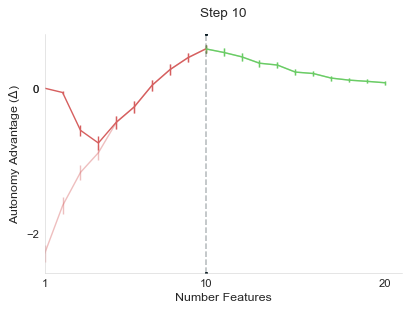

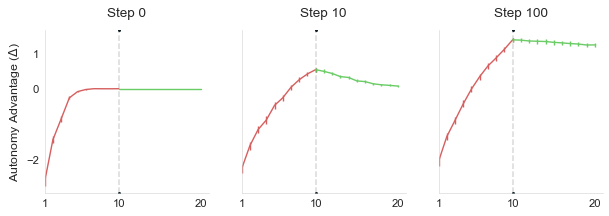

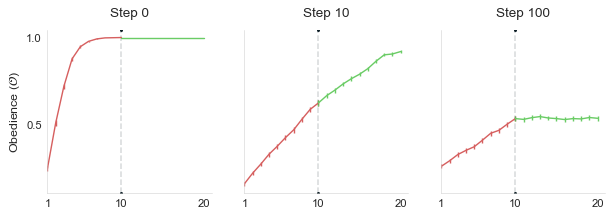

In [216]:
sim_fig34(num_sims=1000, save_file_prefix='fig34')

# Questions, comments, changes?

Submit an issue or pull request.